In [91]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load

In [2]:
train = pd.read_csv('./data/insurance/train.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
## The classes are highly unbalanced towards the 0-class, i.e. most customers are not interested in vehicle insurance
train[train['Response']==0].shape[0]/train.shape[0]

0.877436638861848

In [53]:
## Preprocessing pipeline which performs a one-hot-encoding for all categorical features and returns a train-test-split
def preprocessing(df):
    processed = df.copy()
    processed.drop('id', axis=1, inplace=True)
    processed['Policy_Sales_Channel'] = processed['Policy_Sales_Channel'].astype('int32').astype('category')
    #processed.drop('Policy_Sales_Channel', axis=1, inplace=True)
    processed['Region_Code'] = processed['Region_Code'].astype('int32').astype('category')
    #processed.drop('Region_Code', axis=1, inplace=True)
    processed = pd.get_dummies(processed,drop_first=True)  ##OneHotEncoding
    X = processed.drop('Response', axis=1)
    y = processed['Response']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test    

In [70]:
## Calculates important metrics to evaluate the performance of a classifier
def eval_clf_perf(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('accuracy: ', (tn + tp)/(tn+tp+fn+tp))
    print('sensitivity: ', (tp)/(tp+fn))
    print('precision: ', tp/(tp+fp))

In [71]:
## Displays the calibration curve which helps to evaluate how close the predicted class probabilities correspond to actual probabilites
def eval_clf_calib(clf, X_test, y_test, clf_name=''):
    probs = clf.predict_proba(X_test)[:,1] #probabilities of class 1
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5, strategy='quantile')
    disp = CalibrationDisplay(prob_true, prob_pred, probs, estimator_name=clf_name)
    disp.plot()
    plt.show()

In [72]:
## Calculates the ROC curve and AUC score
def eval_clf_roc(clf, X_test, y_test, clf_name=''):
    fpr, tpr, _ = roc_curve(y_test.values, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=clf_name)
    display.plot()
    plt.show()

In [73]:
## Plot histogram of the predicted class probabilites
def class_probs_hist(clf, X_test, clf_name=''):
    probs = clf.predict_proba(X_test)[:,1]
    sns.histplot(probs, stat='probability')
    plt.title(clf_name)
    plt.show()

In [74]:
## Bundle evaluation functions
def eval_clf(clf, X_test, y_test, clf_name=''):
    eval_clf_perf(clf, X_test, y_test)
    eval_clf_calib(clf, X_test, y_test)
    eval_clf_roc(clf, X_test, y_test)
    class_probs_hist(clf, X_test, clf_name)

In [76]:
X_train, X_test, y_train, y_test = preprocessing(train)

accuracy:  0.8748716677877296
sensitivity:  0.13934078370349412
precision:  0.3727530747398297


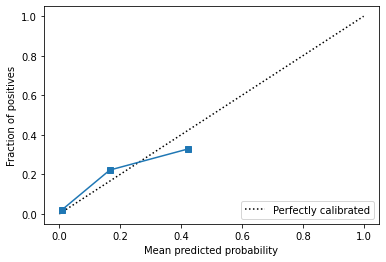

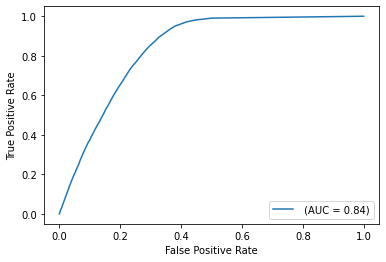

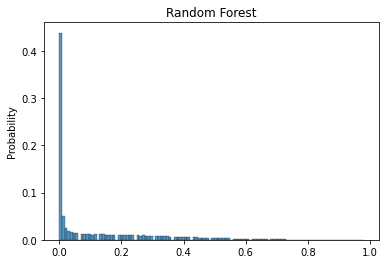

In [75]:
rf = RandomForestClassifier().fit(X_train, y_train)
eval_clf(rf, X_test, y_test, clf_name='Random Forest')

accuracy:  0.8762375804263142
sensitivity:  0.0020512095062950914
precision:  0.1858974358974359


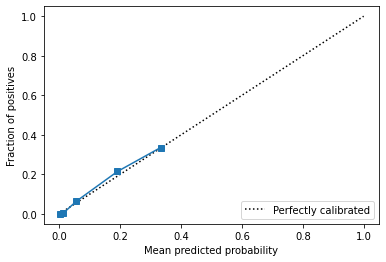

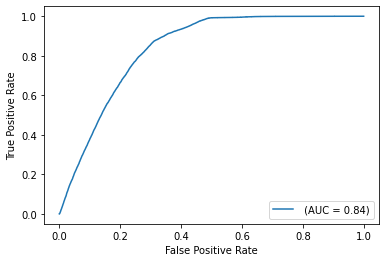

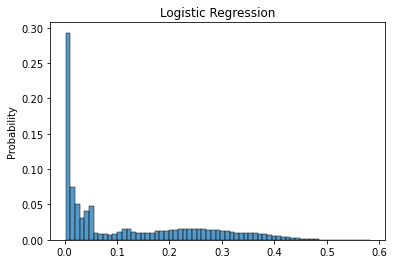

In [88]:
lr = LogisticRegression().fit(X_train, y_train)
eval_clf(lr, X_test, y_test, clf_name='Logistic Regression')

accuracy:  0.8760042097877565
sensitivity:  0.056868015277974256
precision:  0.4185320145757418


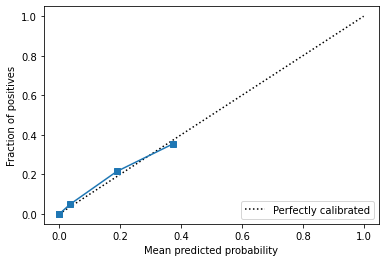

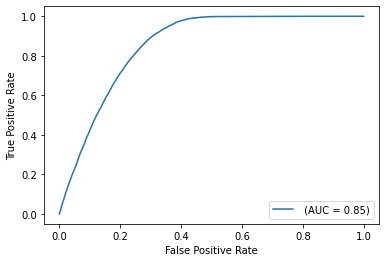

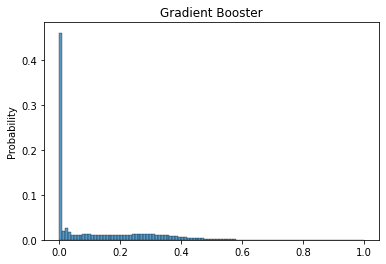

In [79]:
gb = GradientBoostingClassifier(n_estimators=700,learning_rate=0.1, max_depth=8).fit(X_train, y_train)
eval_clf(gb, X_test, y_test, clf_name='Gradient Booster')

In [92]:
dump(gb, 'gb_est700_rate0.1_maxdepth8.joblib')

['gb_est700_rate0.1_maxdepth8.joblib']

In [81]:
X_calib, X_val, y_calib, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=45)

accuracy:  0.8770549265659504
sensitivity:  0.02879543834640057
precision:  0.3937621832358674


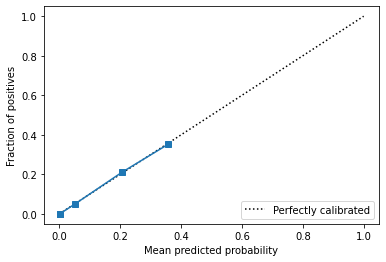

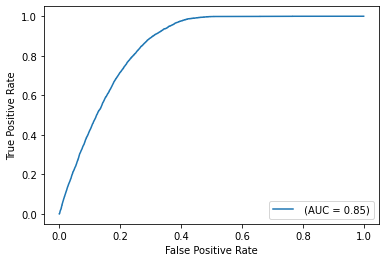

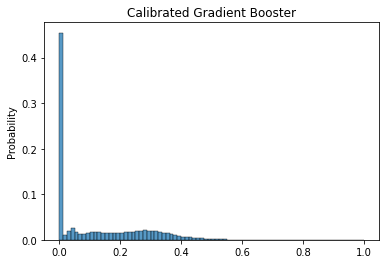

In [87]:
gb_calib = CalibratedClassifierCV(base_estimator=gb, method='sigmoid', cv='prefit').fit(X_calib,y_calib)
eval_clf(gb_calib, X_val, y_val, clf_name='Calibrated Gradient Booster')

accuracy:  0.8762153482380759
sensitivity:  0.0888096935138988
precision:  0.3576349024110218


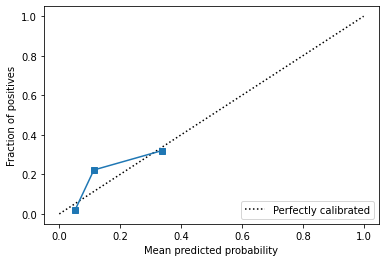

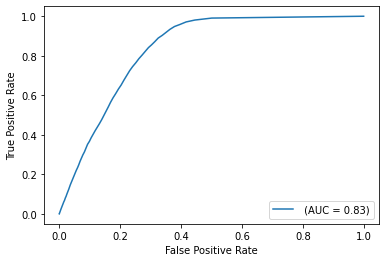

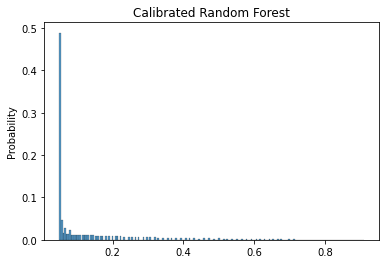

In [86]:
rf_calib = CalibratedClassifierCV(base_estimator=rf, method='sigmoid', cv='prefit').fit(X_calib,y_calib)
eval_clf(rf_calib, X_val, y_val, clf_name='Calibrated Random Forest')

accuracy:  0.8762061537922701
sensitivity:  0.0038194935634460318
precision:  0.2297872340425532


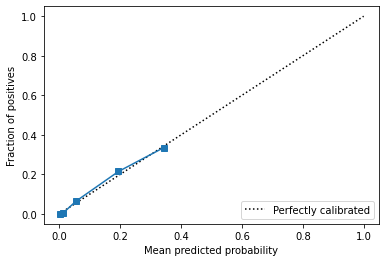

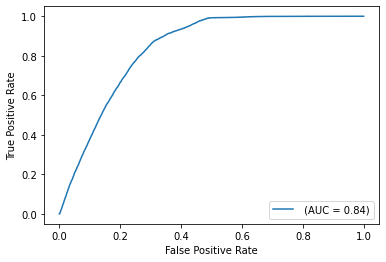

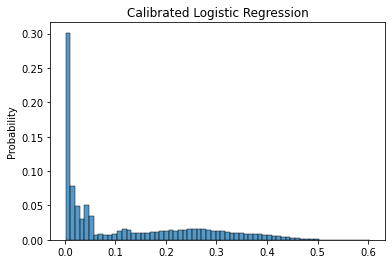

In [90]:
lrc = LogisticRegression()
lr_calib = CalibratedClassifierCV(base_estimator=lrc, method='sigmoid').fit(X_train,y_train)
eval_clf(lr_calib, X_test, y_test, clf_name='Calibrated Logistic Regression')